# Principal notebook

In [1]:
import wandb
from wandb.keras import WandbCallback

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import cv2
from PIL import Image
import albumentations as A
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
import tensorflow_probability as tfp

import sklearn 
from sklearn.metrics import confusion_matrix, roc_curve

import io
import os 

#### Wandb Configuration

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgecardete. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project = "Malaria_Disease",
           config = {
            "LEARNING_RATE": 0.001,
            "N_EPOCHS": 5,
            "BATCH_SIZE": 128,
            "DROPOUT_RATE": 0.0,
            "IM_SIZE": 224,
            "REGULARIZATION_RATE": 0.0,
            "N_FILTERS": 6,
            "KERNEL_SIZE": 3,
            "N_STRIDES": 1,
            "POOL_SIZE": 2,
            "N_DENSE_1": 100,
            "N_DENSE_2": 10,
             })

## Dataset creation with WandB

In [4]:
dataset =  tf.data.Dataset.load(r"C:\Users\jorge\DataSets\MalariaDS")

In [6]:
k = 0
for data in dataset:
    with open(r"C:\Users\jorge\DataSets\\" + str(k) + ".npz", mode = "wb") as file:
        np.savez(file, image=data[0], label=data[1])
    k += 1
    if k%1000 == 0:
        print(k)

KeyboardInterrupt: 

In [7]:

def load_original_data():
  with wandb.init(project="Malaria_Disease") as run:
    
    original_data = wandb.Artifact(
        name = "new_dataset", 
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )
    
    original_data.add_dir(r"C:\Users\jorge\DataSets\Malaria WandB\\")

    run.log_artifact(original_data)

In [8]:
load_original_data()

wandb: Adding directory to artifact (C:\Users\jorge\DataSets\Malaria WandB)... Done. 271.6s


### Basic EDA

In [9]:
category_counts = {0: 0, 1: 0}

for sample in dataset:
    label = sample[1].numpy() 
    category_counts[label] += 1

print(f"The dataset has a total of {len(dataset)} images of which {category_counts[0]} don´t have the disease and {category_counts[1]} have the disease")

The dataset has a total of 27558 images of which 13779 don´t have the disease and 13779 have the disease


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


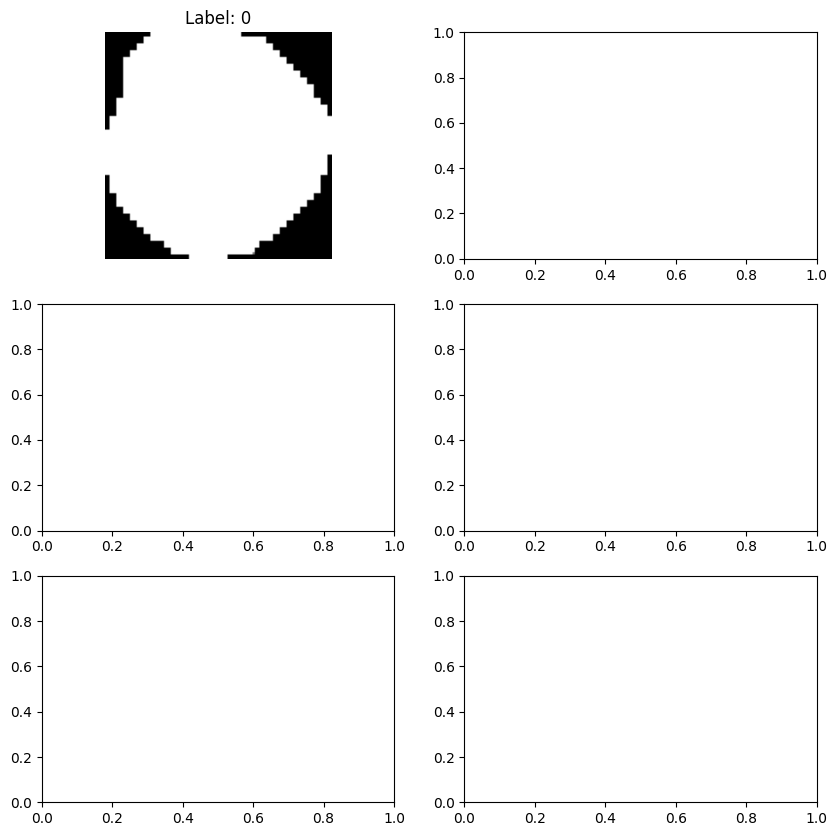

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [41]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
target_size = (100, 100)

for i, sample in enumerate(dataset.take(5)):
    image = sample[0]  
    label = sample[1]  

    image = tf.image.resize(image, target_size)

    label = label.numpy()

    row = i // 2
    col = i % 2
    axes[row, col].imshow(image.numpy())
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

    plt.show()

In [19]:
image_sizes = defaultdict(int)

# Iterate through the dataset to collect image size information
for sample in dataset:
    image = sample[0]  # Replace 'image' with the actual key in your dataset
    width, height, _ = image.shape
    image_sizes[(width, height)] += 1

# Print the count of each unique image size
for size, count in image_sizes.items():
    print(f"Image size: {size[0]} x {size[1]} pixels, Count: {count} images")

Image size: 103 x 103 pixels, Count: 32 images
Image size: 115 x 157 pixels, Count: 17 images
Image size: 136 x 127 pixels, Count: 160 images
Image size: 166 x 139 pixels, Count: 13 images
Image size: 148 x 133 pixels, Count: 83 images
Image size: 112 x 106 pixels, Count: 53 images
Image size: 106 x 112 pixels, Count: 79 images
Image size: 124 x 130 pixels, Count: 170 images
Image size: 124 x 127 pixels, Count: 200 images
Image size: 142 x 136 pixels, Count: 132 images
Image size: 163 x 127 pixels, Count: 17 images
Image size: 109 x 115 pixels, Count: 64 images
Image size: 157 x 136 pixels, Count: 33 images
Image size: 124 x 142 pixels, Count: 79 images
Image size: 133 x 154 pixels, Count: 41 images
Image size: 124 x 115 pixels, Count: 128 images
Image size: 151 x 130 pixels, Count: 45 images
Image size: 115 x 121 pixels, Count: 97 images
Image size: 121 x 118 pixels, Count: 131 images
Image size: 136 x 151 pixels, Count: 61 images
Image size: 106 x 115 pixels, Count: 53 images
Image s

The dataset contains a lot of images with different sizes, therefore we will have to resize it clearly. This may affect the analysis as the resolution of the images will change. In the Preprocessing phase I will decide in which way I rescale the images. 

Now I will explore the color channel configuration.

In [21]:
dataset = tf.data.Dataset.load(dataset_directory)

# Initialize a dictionary to store the channel configurations and their counts
channel_configurations = defaultdict(int)

# Iterate through the dataset to count channel configurations
for sample in dataset:
    image = sample[0]  # Replace 'image' with the actual key in your dataset
    num_channels = image.shape[-1]
    channel_configurations[num_channels] += 1

# Print the count of images for each channel configuration
for channels, count in channel_configurations.items():
    print(f"Channel Configuration: {channels} channels, Count: {count} images")

Channel Configuration: 3 channels, Count: 27558 images


In this case it won´t be necessary to make any modifications since all the images are in the channel RGB. 

In [ ]:
artifact = wandb.use_artifact("jorgecardete/Malaria_Disease/new_dataset:v0")

## Data Preprocessing

In [25]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

def preprocess_data():
  with wandb.init(project="Malaria_Detection", entity="jorgecardete") as run:

    artifact = run.use_artifact("jorgecardete/Malaria_Disease/new_dataset:v0", type='raw_data')
    artifact_dir = artifact.download()

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset", 
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",
        
    )

    artifact_directory = "artifacts/new_dataset:v1/"

    dataset_x = []
    dataset_y = []
    
    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)
    
    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)

In [26]:
preprocess_data()

wandb: Downloading large artifact new_dataset:v0, 1419.75MB. 27558 files... 
wandb:   27558 of 27558 files downloaded.  
Done. 0:6:1.9
Traceback (most recent call last):
  File "C:\Users\jorge\AppData\Local\Temp\ipykernel_26616\311116158.py", line 23, in preprocess_data
    for f in os.listdir(artifact_directory)[:1000]:
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'artifacts/new_dataset:v1/'


wandb: ERROR Control-C detected -- Run data was not synced


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'artifacts/new_dataset:v1/'

### Splitting

In [42]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset 

In [43]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

## Data Splitting

In [ ]:

def split_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
    artifact_dir = artifact.download()

    train_data = wandb.Artifact(
        name = "train_dataset", 
        type="preprocessed_data",
        description = "Training dataset",
        
    )
    val_data = wandb.Artifact(
        
        name = "val_dataset", 
        type="preprocessed_data",
        description = "Validation dataset",
            
        )
    test_data = wandb.Artifact(
        name = "test_dataset", 
        type="preprocessed_data",
        description = "Test dataset",
            
        )
    
    artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1
    
    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]
    
      
    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)
        
    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)
        
    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)
        

    run.log_artifact(train_data)  
    run.log_artifact(val_data)      
    run.log_artifact(test_data)
     

In [ ]:
split_data()

#### Augmentation

In [ ]:
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [ ]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset", 
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"
    
    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:

augment_data()

### Model description

In [ ]:

IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

In [ ]:
lenet_model.summary()

### Model deployment

In [ ]:

def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    sequential_model = wandb.Artifact(
        name = "Sequential_model", 
        type="model",
        description = "A trained version of our model",
        
    )

    artifact_file = "artifacts/train_dataset:v0/aug_dataset.npz"
    
    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)
        
        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

        metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
                     BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        FACTOR = 1
        LABELS = ['Parasitized', 'Uninfected']


        lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
               loss = BinaryCrossentropy(),
               metrics = metrics)

        history = lenet_model.fit(
            train_dataset,
            validation_data = val_dataset,
            epochs = CONFIGURATION['N_EPOCHS'],
             verbose = 1,
             callbacks=[LogImagesCallbackWandB()]
             )

    with preprocessed_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])

    run.log_artifact(preprocessed_data)
     